In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Cell 1 — Imports & paths (fixed)
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

%matplotlib inline

BASE = Path("/content/drive/MyDrive")
HOSP = BASE / "mimiciv/3.1/hosp"
NOTE = BASE / "mimic-iv-note/2.2/note"

pd.options.display.max_rows = 20
pd.options.display.max_columns = 50

print("Paths OK:", HOSP.exists(), NOTE.exists())

Paths OK: True True


In [ ]:
usecols_adm = ["subject_id","hadm_id","admittime"]
usecols_pat = ["subject_id","gender","anchor_age","anchor_year"]
usecols_dx  = ["subject_id","hadm_id","icd_code","icd_version"]

adm = pd.read_csv(HOSP/"admissions.csv.gz", usecols=usecols_adm, parse_dates=["admittime"])
pat = pd.read_csv(HOSP/"patients.csv.gz",   usecols=usecols_pat)
dx  = pd.read_csv(HOSP/"diagnoses_icd.csv.gz", usecols=usecols_dx)
dicd = pd.read_csv(HOSP/"d_icd_diagnoses.csv.gz")  # để tra tên bệnh

len(adm), len(pat), len(dx)


(546028, 364627, 6364488)

In [ ]:
n_adm = adm["hadm_id"].nunique()
n_pt  = pat["subject_id"].nunique()
n_dx  = len(dx)
print(f"Admissions: {n_adm:,} | Patients: {n_pt:,} | Diagnosis rows: {n_dx:,}")

print("Giới tính:")
print(pat["gender"].value_counts(dropna=False).to_frame("count").assign(
    pct=lambda d: (100*d["count"]/d["count"].sum()).round(2)
))


Admissions: 546,028 | Patients: 364,627 | Diagnosis rows: 6,364,488
Giới tính:
         count    pct
gender               
F       191984  52.65
M       172643  47.35


In [ ]:
# age_at_admit ≈ anchor_age + (year(admittime) - anchor_year), clip 0..120
adm_pat = adm.merge(pat, on="subject_id", how="left")
age = adm_pat["anchor_age"] + (adm_pat["admittime"].dt.year - adm_pat["anchor_year"])
adm_pat["age_at_admit"] = age.clip(lower=0, upper=120)

adm_pat["age_at_admit"].describe(percentiles=[.1,.25,.5,.75,.9]).round(2)


count    546028.00
mean         59.16
std          19.15
min          18.00
10%          31.00
25%          45.00
50%          61.00
75%          74.00
90%          84.00
max         106.00
Name: age_at_admit, dtype: float64

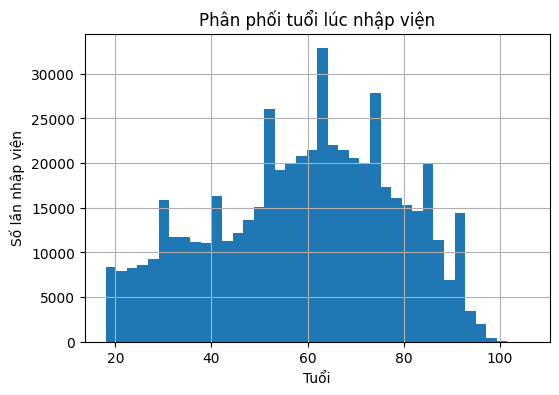

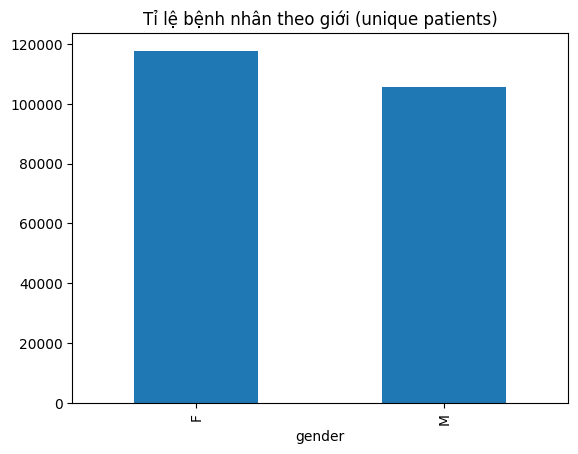

,count,pct
gender,,
F,117736,52.69
M,105716,47.31


In [ ]:
fig = plt.figure(figsize=(6,4))
adm_pat["age_at_admit"].dropna().astype(int).hist(bins=40)
plt.title("Phân phối tuổi lúc nhập viện")
plt.xlabel("Tuổi"); plt.ylabel("Số lần nhập viện")
plt.show()

sex_dist = adm_pat.drop_duplicates("subject_id")["gender"].value_counts()
sex_dist.plot(kind="bar"); plt.title("Tỉ lệ bệnh nhân theo giới (unique patients)"); plt.show()

sex_dist.to_frame("count").assign(pct=lambda d: (100*d["count"]/d["count"].sum()).round(2))


In [ ]:
# Đếm theo hadm_id-icd (mỗi ICD tính 1 lần/nhập viện)
dx_unique = dx.drop_duplicates(["hadm_id","icd_code","icd_version"]).copy()
dx_unique["icd_full"] = dx_unique["icd_version"].astype(str)+"-"+dx_unique["icd_code"].astype(str)

icd_counts = dx_unique["icd_full"].value_counts().to_frame("hadm_freq")
icd_counts.head(10)


,hadm_freq
icd_full,
9-4019,102362
10-E785,84568
10-I10,83773
9-2724,67288
10-Z87891,62803
10-K219,56155
9-53081,48624
9-25000,43076
10-F329,41876


In [ ]:
thresholds = [10, 20, 50, 100, 200, 500]
out = []
total_labels = icd_counts.shape[0]
total_hadm = adm["hadm_id"].nunique()

for t in thresholds:
    lbl = (icd_counts["hadm_freq"]>=t).sum()
    cov = dx_unique[dx_unique["icd_full"].isin(icd_counts[icd_counts["hadm_freq"]>=t].index)]
    hadm_cov = cov["hadm_id"].nunique()
    out.append({"threshold": t, "num_labels": lbl,
                "pct_labels": round(100*lbl/total_labels, 2),
                "hadm_covered": hadm_cov,
                "pct_hadm": round(100*hadm_cov/total_hadm, 2)})

pd.DataFrame(out)


,threshold,num_labels,pct_labels,hadm_covered,pct_hadm
0,10,12850,44.96,545337,99.87
1,20,9863,34.51,545114,99.83
2,50,6565,22.97,544447,99.71
3,100,4682,16.38,543608,99.56
4,200,3113,10.89,541951,99.25
5,500,1783,6.24,538461,98.61


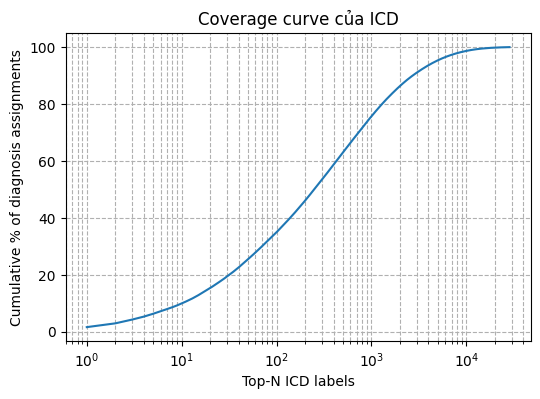

,icd_full,hadm_freq,cum_hadm,cum_pct_hadm
0,9-4019,102362,102362,1.608429
1,10-E785,84568,186930,2.937257
2,10-I10,83773,270703,4.253594
3,9-2724,67288,337991,5.310900
4,10-Z87891,62803,400794,6.297733
5,10-K219,56155,456949,7.180104
6,9-53081,48624,505573,7.944140
7,9-25000,43076,548649,8.620999
8,10-F329,41876,590525,9.279003
9,10-I2510,41548,632073,9.931852


In [ ]:
icd_counts_sorted = icd_counts.sort_values("hadm_freq", ascending=False).reset_index(drop=False)
icd_counts_sorted["cum_hadm"] = icd_counts_sorted["hadm_freq"].cumsum()
icd_counts_sorted["cum_pct_hadm"] = 100 * icd_counts_sorted["cum_hadm"] / icd_counts_sorted["hadm_freq"].sum()

fig = plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(icd_counts_sorted)+1), icd_counts_sorted["cum_pct_hadm"])
plt.xlabel("Top-N ICD labels"); plt.ylabel("Cumulative % of diagnosis assignments")
plt.title("Coverage curve của ICD")
plt.xscale("log"); plt.grid(True, which="both", ls="--")
plt.show()

icd_counts_sorted.head(20)


In [ ]:
# Bước 9 — Top ICD (kèm tên bệnh) — ROBUST FIX
# Tính tần suất ICD theo lần nhập viện
dxu = dx.drop_duplicates(["hadm_id","icd_code","icd_version"]).copy()
dxu["icd_full"] = dxu["icd_version"].astype(str) + "-" + dxu["icd_code"].astype(str)

icd_counts_sorted = (
    dxu.groupby("icd_full")["hadm_id"]
       .nunique()
       .sort_values(ascending=False)
       .reset_index(name="hadm_freq")
)

# Loại trùng tên cột nếu có
icd_counts_sorted = icd_counts_sorted.loc[:, ~icd_counts_sorted.columns.duplicated()]

topk = 30
top_icd = icd_counts_sorted.head(topk).copy()
top_icd["icd_code_only"] = top_icd["icd_full"].astype(str).str.split("-", n=1).str[1]

dicd_small = dicd[["icd_code","long_title"]].rename(columns={"icd_code":"icd_code_only"})
top_icd = top_icd.merge(dicd_small, on="icd_code_only", how="left")

top_icd = top_icd[["icd_full","hadm_freq","long_title"]]
top_icd.head(30)


,icd_full,hadm_freq,long_title
0,9-4019,102362,Unspecified essential hypertension
1,10-E785,84568,"Hyperlipidemia, unspecified"
2,10-I10,83773,Essential (primary) hypertension
3,9-2724,67288,Other and unspecified hyperlipidemia
4,10-Z87891,62803,Personal history of nicotine dependence
...,...,...,...
25,9-2859,24392,"Anemia, unspecified"
26,10-F17210,24106,"Nicotine dependence, cigarettes, uncomplicated"
27,10-G4733,23933,Obstructive sleep apnea (adult) (pediatric)
28,9-40390,23831,"Hypertensive chronic kidney disease, unspecifi..."


In [ ]:
dxp = dx_unique.merge(pat[["subject_id","gender"]], on="subject_id", how="left")
sex_icd = (dxp.groupby(["gender","icd_full"])["hadm_id"]
             .nunique().reset_index(name="hadm_freq"))
# tỉ lệ theo từng giới
sex_tot = sex_icd.groupby("gender")["hadm_freq"].sum().rename("tot")
sex_icd = sex_icd.merge(sex_tot, on="gender")
sex_icd["pct_within_gender"] = 100*sex_icd["hadm_freq"]/sex_icd["tot"]

# Top 15 ICD phổ biến theo từng giới
for g in sex_icd["gender"].dropna().unique():
    display(sex_icd[sex_icd["gender"]==g]
            .sort_values("hadm_freq", ascending=False)
            .head(15)[["gender","icd_full","hadm_freq","pct_within_gender"]])


,gender,icd_full,hadm_freq,pct_within_gender
17925,F,9-4019,52735,1.652795
3779,F,10-I10,41736,1.308070
1876,F,10-E785,38535,1.207745
16617,F,9-2724,31701,0.993557
5081,F,10-K219,30679,0.961526
18632,F,9-53081,27356,0.857379
15311,F,10-Z87891,27062,0.848164
2268,F,10-F329,24767,0.776235
2302,F,10-F419,24031,0.753168
17134,F,9-311,21585,0.676507


,gender,icd_full,hadm_freq,pct_within_gender
41089,M,9-4019,49627,1.563822
25284,M,10-E785,46033,1.450569
27194,M,10-I10,42037,1.324649
38470,M,10-Z87891,35741,1.126253
39796,M,9-2724,35587,1.121400
27241,M,10-I2510,26923,0.848384
28512,M,10-K219,25476,0.802787
39666,M,9-25000,22270,0.701761
41148,M,9-41401,22086,0.695963
41798,M,9-53081,21268,0.670187


In [3]:
# ONE-CELL: thống kê discharge notes không tràn RAM (Colab/MyDrive/Local đều được)
import pandas as pd, numpy as np, math, random
from pathlib import Path

# Đường dẫn NOTE đã khai báo sẵn; nếu chưa:
# NOTE = Path("/content/drive/MyDrive/mimic-iv-note/2.2/note")

path = NOTE/"discharge.csv" if (NOTE/"discharge.csv").exists() else NOTE/"discharge.csv.gz"

# Đọc header để tìm đúng tên cột (case-insensitive)
hdr = pd.read_csv(path, nrows=0).columns.tolist()
def find_col(names):
    names = {n.lower() for n in names}
    for h in hdr:
        if h.lower() in names: return h
    return None

text_col = find_col(["text","note_text"])
assert text_col, f"Không tìm thấy cột text/note_text trong {path}"

chunksize = 100_000
SAMPLE_MAX = 200_000  # kích thước mẫu để ước lượng percentiles
sample_chars, sample_tokens = [], []

# Welford cho mean/std + min/max + count
n = 0
mean_c = mean_t = 0.0
M2_c = M2_t = 0.0
min_c = math.inf; max_c = -math.inf
min_t = math.inf; max_t = -math.inf
missing = 0

def reservoir_push(sample, value):
    if len(sample) < SAMPLE_MAX:
        sample.append(value)
    else:
        j = random.randint(0, n-1)
        if j < SAMPLE_MAX:
            sample[j] = value

for chunk in pd.read_csv(path, usecols=[text_col], chunksize=chunksize, low_memory=True):
    s = chunk[text_col]
    miss = s.isna() | (s.astype(str).str.lower().isin(["nan","none",""]))
    missing += int(miss.sum())
    s = s[~miss].astype(str)
    if s.empty:
        continue

    # vectorized lengths
    n_chars = s.str.len().to_numpy()
    n_tokens = s.str.count(r"\S+").to_numpy()

    # cập nhật thống kê tổng hợp
    m = len(n_chars)
    for arr, mean, M2, minv, maxv in (
        (n_chars, mean_c, M2_c, min_c, max_c),
        (n_tokens, mean_t, M2_t, min_t, max_t),
    ):
        arr_mean = float(arr.mean())
        delta = arr_mean - (mean_c if arr is n_chars else mean_t)
        if arr is n_chars:
            mean_c += (m/(n+m)) * delta if (n+m)>0 else arr_mean
            # M2 update với mean theo batch
            M2_c += ((n*m)/(n+m)) * (delta**2) if n>0 else 0.0
            min_c = min(min_c, int(arr.min()))
            max_c = max(max_c, int(arr.max()))
        else:
            mean_t += (m/(n+m)) * delta if (n+m)>0 else arr_mean
            M2_t += ((n*m)/(n+m)) * (delta**2) if n>0 else 0.0
            min_t = min(min_t, int(arr.min()))
            max_t = max(max_t, int(arr.max()))

    # reservoir sample cho percentiles
    for c_len, t_len in zip(n_chars, n_tokens):
        n += 1
        reservoir_push(sample_chars, int(c_len))
        reservoir_push(sample_tokens, int(t_len))

# std từ M2 + tinh chỉnh: cộng phương sai nội-batch đã bỏ qua (xấp xỉ đủ tốt cho quan sát thô)
std_chars = (math.sqrt(M2_c/max(n-1,1)) if n>1 else 0.0)
std_tokens = (math.sqrt(M2_t/max(n-1,1)) if n>1 else 0.0)

# percentiles từ mẫu
def pcts(arr):
    if not arr: return {"25%":0,"50%":0,"75%":0,"90%":0}
    q = np.percentile(np.asarray(arr), [25,50,75,90])
    return {"25%":int(q[0]), "50%":int(q[1]), "75%":int(q[2]), "90%":int(q[3])}

pct_c = pcts(sample_chars)
pct_t = pcts(sample_tokens)

summary = pd.DataFrame({
    "count":   [n, n],
    "mean":    [round(mean_c,2), round(mean_t,2)],
    "std":     [round(std_chars,2), round(std_tokens,2)],
    "min":     [0 if min_c is math.inf else min_c, 0 if min_t is math.inf else min_t],
    "25%":     [pct_c["25%"], pct_t["25%"]],
    "50%":     [pct_c["50%"], pct_t["50%"]],
    "75%":     [pct_c["75%"], pct_t["75%"]],
    "90%":     [pct_c["90%"], pct_t["90%"]],
    "max":     [0 if max_c == -math.inf else max_c, 0 if max_t == -math.inf else max_t],
    "missing": [missing, missing],
}, index=["n_chars","n_tokens"])

print(f"File: {path} | text_col='{text_col}'")
summary


File: /content/drive/MyDrive/mimic-iv-note/2.2/note/discharge.csv | text_col='text'


,count,mean,std,min,25%,50%,75%,90%,max,missing
n_chars,331793,10550.96,16.23,353,7467,9849,12844,16169,60381,0
n_tokens,331793,1600.27,2.34,44,1136,1501,1952,2444,9026,0


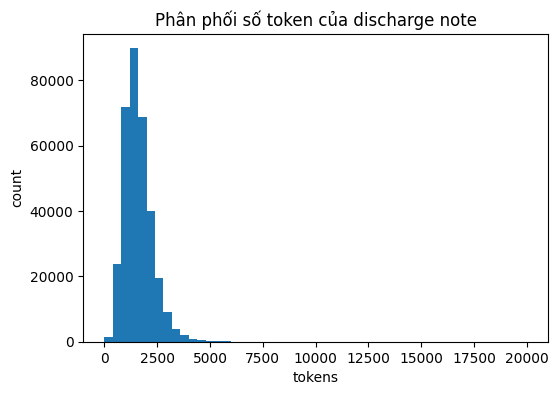

,age_bin,median_tokens,n_samples
0,"(0,20]",1217,2911
1,"(20,40]",1284,5000
2,"(40,60]",1449,5000
3,"(60,80]",1583,5000
4,"(80,120]",1634,5000


In [5]:
# ONE-CELL: Histogram n_tokens + median theo dải tuổi, không tràn RAM
import pandas as pd, numpy as np, math, random
from pathlib import Path
import matplotlib.pyplot as plt

# ---- Paths (đã có HOSP/NOTE từ bước trước). Nếu chưa, set nhanh:
# BASE = Path("/content/drive/MyDrive")
# HOSP = BASE / "mimiciv/3.1/hosp"
# NOTE = BASE / "mimic-iv-note/2.2/note"

# 1) Bản đồ tuổi lúc nhập viện (nhỏ, load vào RAM)
usecols_adm = ["subject_id","hadm_id","admittime"]
usecols_pat = ["subject_id","anchor_age","anchor_year"]
adm = pd.read_csv(HOSP/"admissions.csv.gz", usecols=usecols_adm, parse_dates=["admittime"])
pat = pd.read_csv(HOSP/"patients.csv.gz",   usecols=usecols_pat)
adm_pat = adm.merge(pat, on="subject_id", how="left")
age = adm_pat["anchor_age"] + (adm_pat["admittime"].dt.year - adm_pat["anchor_year"])
adm_pat["age_at_admit"] = age.clip(lower=0, upper=120)
age_map = adm_pat[["subject_id","hadm_id","age_at_admit"]]

# 2) Tìm cột text & chuẩn bị đọc chunks
path = NOTE/"discharge.csv" if (NOTE/"discharge.csv").exists() else NOTE/"discharge.csv.gz"
hdr = pd.read_csv(path, nrows=0).columns.tolist()
def find_col(names):
    names = {n.lower() for n in names}
    for h in hdr:
        if h.lower() in names: return h
    return None
text_col = find_col(["text","note_text"])
assert text_col, f"Không tìm thấy cột text/note_text trong {path}"

chunksize = 100_000

# 3) Histogram n_tokens (clip tối đa 20000) — đếm trực tiếp
bins = np.linspace(0, 20000, 51)  # 50 bins
hist_counts = np.zeros(len(bins)-1, dtype=np.int64)

# 4) Median n_tokens theo dải tuổi — reservoir sampling per-bin
age_bins = [0,20,40,60,80,120]
age_labels = pd.IntervalIndex.from_tuples(list(zip(age_bins[:-1], age_bins[1:])), closed='right')
SAMPLE_MAX_PER_BIN = 5000
samples_per_bin = {iv: [] for iv in age_labels}

def push_sample(bin_key, value):
    buf = samples_per_bin[bin_key]
    total = len(buf)
    if total < SAMPLE_MAX_PER_BIN:
        buf.append(value)
    else:
        j = random.randint(0, total)  # simple reservoir within bin
        if j < SAMPLE_MAX_PER_BIN:
            buf[j] = value

# 5) Duyệt từng chunk: lấy subject_id/hadm_id/text -> merge age -> tính tokens
usecols = ["subject_id","hadm_id", text_col]
for chunk in pd.read_csv(path, usecols=usecols, chunksize=chunksize, low_memory=True):
    chunk = chunk.merge(age_map, on=["subject_id","hadm_id"], how="left")
    s = chunk[text_col].astype(str)
    miss = s.isna() | (s.str.lower().isin(["nan","none",""]))
    s = s[~miss]
    if s.empty:
        continue
    tokens = s.str.count(r"\S+").to_numpy()

    # Histogram
    t_clip = np.clip(tokens, bins[0], bins[-1]-1)
    hist_counts += np.histogram(t_clip, bins=bins)[0]

    # Sampling theo bin tuổi
    age_vals = chunk.loc[s.index, "age_at_admit"].to_numpy()
    # Gán bin
    age_idx = np.digitize(age_vals, age_bins, right=True) - 1
    for val_tok, idx in zip(tokens, age_idx):
        if 0 <= idx < len(age_bins)-1:
            push_sample(age_labels[idx], int(val_tok))

# 6) Tính median theo bin tuổi từ samples
rows = []
for iv in age_labels:
    arr = np.asarray(samples_per_bin[iv], dtype=int)
    med = int(np.median(arr)) if arr.size else 0
    rows.append({"age_bin": f"({iv.left},{iv.right}]",
                 "median_tokens": med,
                 "n_samples": int(arr.size)})
note_len_by_age = pd.DataFrame(rows)

# 7) Vẽ histogram
plt.figure(figsize=(6,4))
centers = (bins[:-1] + bins[1:]) / 2
plt.bar(centers, hist_counts, width=(bins[1]-bins[0]))
plt.title("Phân phối số token của discharge note")
plt.xlabel("tokens"); plt.ylabel("count")
plt.show()

# 8) Kết quả bảng median theo dải tuổi
note_len_by_age.sort_values("age_bin")


In [6]:
adm_pat["dow"] = adm_pat["admittime"].dt.day_name()
age_bins = [0,10,20,30,40,50,60,70,80,90,120]
age_dist = pd.cut(adm_pat["age_at_admit"], bins=age_bins).value_counts().sort_index()
dow_dist  = adm_pat["dow"].value_counts()

display(age_dist.to_frame("admissions").assign(pct=lambda d: (100*d["admissions"]/d["admissions"].sum()).round(2)))
display(dow_dist.to_frame("admissions").assign(pct=lambda d: (100*d["admissions"]/d["admissions"].sum()).round(2)))


,admissions,pct
age_at_admit,,
"(0, 10]",0,0.00
"(10, 20]",8358,1.53
"(20, 30]",44183,8.09
"(30, 40]",56713,10.39
"(40, 50]",63087,11.55
"(50, 60]",96562,17.68
"(60, 70]",107704,19.72
"(70, 80]",88962,16.29
"(80, 90]",60146,11.02


,admissions,pct
dow,,
Saturday,79049,14.48
Sunday,78359,14.35
Monday,77794,14.25
Friday,77781,14.24
Thursday,77737,14.24
Tuesday,77684,14.23
Wednesday,77624,14.22


In [10]:
# ONE-CELL robust export -> BASE/proc/
import pandas as pd, numpy as np
from pathlib import Path

# Assumes BASE/HOSP/NOTE defined; set fallback if needed
try: BASE; HOSP; NOTE
except NameError:
    BASE = Path("/content/drive/MyDrive")
    HOSP = BASE/"mimiciv/3.1/hosp"
    NOTE = BASE/"mimic-iv-note/2.2/note"

PROC = BASE/"proc"; PROC.mkdir(parents=True, exist_ok=True)

# --- Load admissions & patients (robust headers) ---
adm = pd.read_csv(HOSP/"admissions.csv.gz",
                  usecols=["subject_id","hadm_id","admittime"],
                  parse_dates=["admittime"])

# read header then pick available names
hdr_pat = pd.read_csv(HOSP/"patients.csv.gz", nrows=0).columns
lk = {h.lower(): h for h in hdr_pat}
cols_pat = ["subject_id", lk.get("gender") or lk.get("sex"), "anchor_age", "anchor_year"]
cols_pat = [c for c in cols_pat if c is not None]
pat = pd.read_csv(HOSP/"patients.csv.gz", usecols=cols_pat)

# normalize gender column name
if any(c.lower()=="sex" for c in pat.columns):
    pat = pat.rename(columns={lk["sex"]: "gender"})
elif not any(c.lower()=="gender" for c in pat.columns):
    pat["gender"] = "U"  # Unknown

# --- Build adm_pat + age ---
adm_pat = adm.merge(pat, on="subject_id", how="left")
adm_pat["age_at_admit"] = (
    adm_pat["anchor_age"] + (adm_pat["admittime"].dt.year - adm_pat["anchor_year"])
).clip(lower=0, upper=120)

# --- dx -> icd_counts ---
dx = pd.read_csv(HOSP/"diagnoses_icd.csv.gz",
                 usecols=["subject_id","hadm_id","icd_code","icd_version"])
dxu = dx.drop_duplicates(["hadm_id","icd_code","icd_version"]).copy()
dxu["icd_full"] = dxu["icd_version"].astype(str) + "-" + dxu["icd_code"].astype(str)
icd_counts = dxu["icd_full"].value_counts().to_frame("hadm_freq")
icd_counts_sorted = (icd_counts.reset_index()
                     .rename(columns={"index":"icd_full"})
                     .sort_values("hadm_freq", ascending=False))

icd_counts.to_csv(PROC/"icd_hadm_freq.csv")
icd_counts_sorted.head(5000).to_csv(PROC/"top_icd_coverage.csv", index=False)

# --- demographics (gender may be 'U') ---
adm_pat[["subject_id","hadm_id","gender","age_at_admit"]].to_csv(
    PROC/"admit_demographics.csv", index=False
)

# --- note_lengths: stream (no RAM blow-up) ---
note_path = NOTE/("discharge.csv" if (NOTE/"discharge.csv").exists() else "discharge.csv.gz")
hdr = pd.read_csv(note_path, nrows=0).columns
lk = {h.lower(): h for h in hdr}
text_col = lk.get("text") or lk.get("note_text")
assert text_col, f"Không thấy cột text/note_text trong {note_path}"

out = PROC/"note_lengths.csv"
if out.exists(): out.unlink()
first = True
for chunk in pd.read_csv(note_path, usecols=["subject_id","hadm_id", text_col],
                         chunksize=100_000, low_memory=True):
    s = chunk[text_col].astype(str)
    mask = ~(s.isna() | s.str.lower().isin(["nan","none",""]))
    part = chunk.loc[mask, ["subject_id","hadm_id", text_col]].copy()
    if part.empty: continue
    part["n_chars"]  = part[text_col].str.len().astype("int32")
    part["n_tokens"] = part[text_col].str.count(r"\S+").astype("int32")
    part.drop(columns=[text_col]).to_csv(out, mode="w" if first else "a",
                                         header=first, index=False)
    first = False

print("Saved to:", PROC)


Saved to: /content/drive/MyDrive/proc
